## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

## Create dataset from directory

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input

2024-05-09 17:19:37.133161: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 17:19:37.209809: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 17:19:37.491174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 17:19:39.015500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


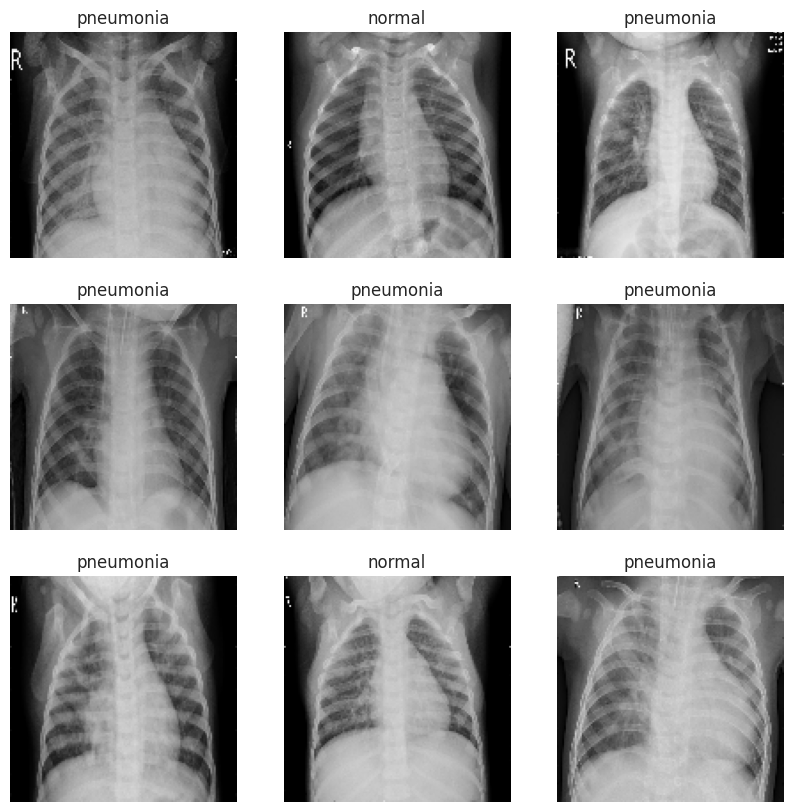

2024-05-09 17:19:46.920164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [4]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

2024-05-09 17:19:55.258822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

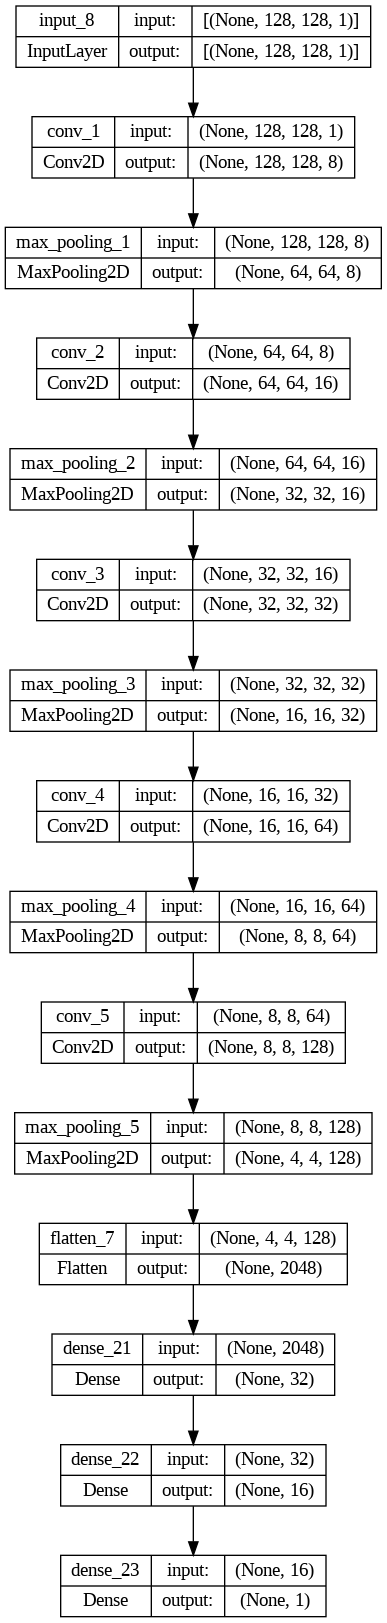

In [13]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name='input_8')

l1 = Conv2D(8, (3, 3), padding='same', activation='relu', name='conv_1')(input)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='max_pooling_1')(l1)

l2 = Conv2D(16, (3, 3), padding='same', activation='relu', name='conv_2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='max_pooling_2')(l2)

l3 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_3')(l2_mp)
l3_mp = MaxPooling2D(pool_size=(2, 2), name='max_pooling_3')(l3)

l4 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_4')(l3_mp)
l4_mp = MaxPooling2D(pool_size=(2, 2), name='max_pooling_4')(l4)

l5 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_5')(l4_mp)
l5_mp = MaxPooling2D(pool_size=(2, 2), name='max_pooling_5')(l5)

flat = Flatten(name='flatten_7')(l5_mp)


l6 = Dense(32, activation='relu', name='dens_21')(flat)
cnn_output = Dense(16, activation='relu', name='dense_22')(l6)

cnn_output = layers.Dense(1, activation='sigmoid',name='dense_23')(cnn_output)
cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [14]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [21]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - accuracy: 0.9813 - loss: 0.0455 - val_accuracy: 0.9375 - val_loss: 0.1313
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 0.9953 - loss: 0.0117 - val_accuracy: 0.9375 - val_loss: 0.3255
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - accuracy: 0.9991 - loss: 0.0026 - val_accuracy: 0.8750 - val_loss: 0.6271
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - accuracy: 0.9998 - loss: 8.5511e-04 - val_accuracy: 0.9375 - val_loss: 0.1156
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.9995 - loss: 8.7308e-04 - val_accuracy: 0.9375 - val_loss: 0.3379
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step - accuracy: 1.0000 - loss: 7.5694e-05 - val_accuracy: 0.9375 - val_loss: 0.2313
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 1.0000 - loss: 5.4796e-05 - val_accuracy: 0.9375 - val_loss: 0.2315
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 192ms/step - accuracy: 1.0000 - loss: 4

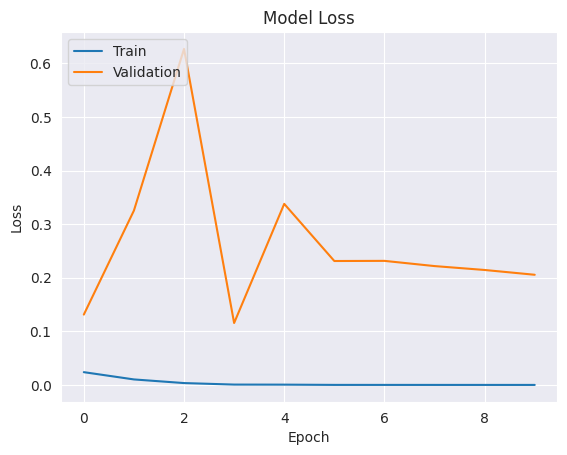

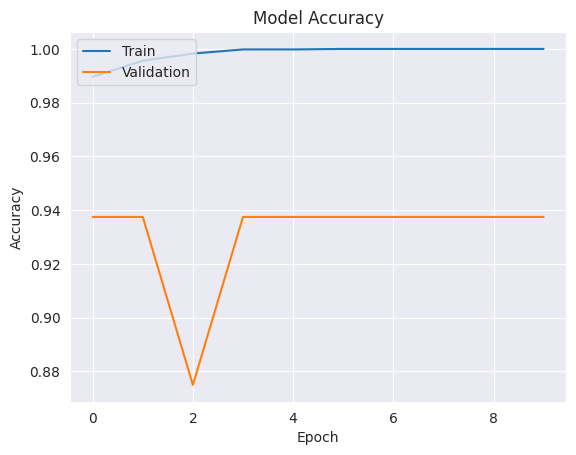

In [22]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

2024-05-09 17:35:10.012911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


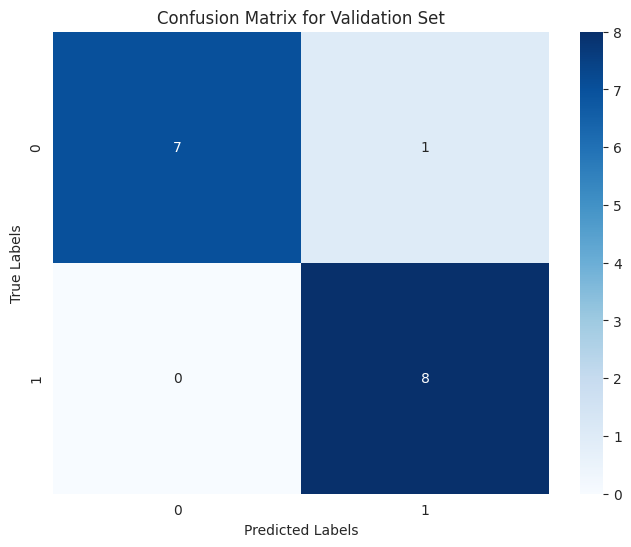

Accuracy: 0.94
Precision: 0.89
Recall: 1.00
F1 Score: 0.94


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set

val_predictions = cnn.predict(val_images)
val_predictions = np.round(val_predictions).astype(int)

cm = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Validation Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Metrics calculation
accuracy = accuracy_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

2024-05-09 17:35:19.838082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


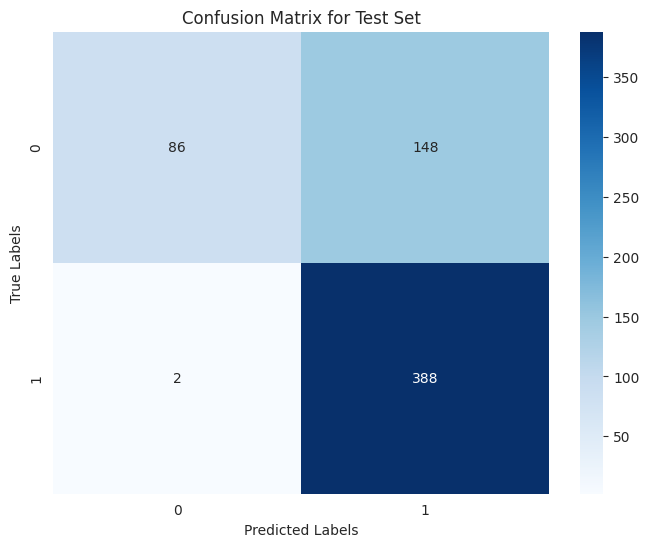

Test Accuracy: 0.76
Test Precision: 0.72
Test Recall: 0.99
Test F1 Score: 0.84


In [24]:
test_images = []
test_labels = []

for img, label in test_ds:
    test_images.append(img)
    test_labels.append(label)

test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels).squeeze().astype(int)

# Predict test set
test_predictions = cnn.predict(test_images)
test_predictions = np.round(test_predictions).astype(int)

# Compute the confusion matrix
test_cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate metrics for the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")